In [1]:
import pandas as pd
import subprocess
import os
import matplotlib.pyplot as plt
directory = '../data/curvibacter_dna_genomes_for_rec_blast/'

In [4]:
if os.path.isfile("../data/curvibacter_assemblies.table") == False:
    !esearch -db assembly -query "Curvibacter [ORGN]" | efetch -format docsum | xtract -pattern DocumentSummary -element Id AssemblyAccession AssemblyName AssemblyStatus SubmissionDate FtpPath_GenBank Taxid Organism SpeciesTaxid SpeciesName > ../data/curvibacter_assemblies.table
else:
    print("[*] Table Exists!")

[*] Table Exists!


In [5]:
cols = ['Id', 'AssemblyAccession', 'AssemblyName', 'AssemblyStatus', 'SubmissionDate','FtpPath_GenBank', 'Taxid', 'Organism', 'SpeciesTaxid', 'SpeciesName']
assemblies = pd.read_table('../data/curvibacter_assemblies.table',header=None)
assemblies.columns = cols
assemblies.head()

,Id,AssemblyAccession,AssemblyName,AssemblyStatus,SubmissionDate,FtpPath_GenBank,Taxid,Organism,SpeciesTaxid,SpeciesName
0,11312701,GCA_020621995.1,ASM2062199v1,Contig,2021/10/26 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
1,11312681,GCA_020621965.1,ASM2062196v1,Scaffold,2021/10/26 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
2,11068931,GCA_020248905.1,ASM2024890v1,Contig,2021/10/04 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
3,10501171,GCA_019233055.1,ASM1923305v1,Contig,2021/07/15 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
4,10449501,GCA_019163435.1,ASM1916343v1,Scaffold,2021/07/07 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019...,86182,Curvibacter lanceolatus (b-proteobacteria),86182,Curvibacter lanceolatus


# Producing Input For Reciprocal BLAST Database

In [3]:
if os.path.isdir("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database") == False:
    !mkdir ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database
else:
    print("[*] Directory Exists!")

[*] Directory Exists!


In [24]:
if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/organisms.txt") == False:
    with open("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/organisms.txt",'w') as ofile:
        for line in assemblies['SpeciesName']:
            ofile.write(line+'\n')
else:
    print("[*] Organisms File Exists!")

In [6]:
dirs = !ls -d ../data/curvibacter_dna_genomes_for_rec_blast/prokka/*
dirs = [d for d in dirs if d.split("/")[-1] != "database"]

In [7]:
ass = [d.split("/")[-1] for d in dirs]

In [16]:
assembly_list = [a.split(".")[0] for a in assemblies['AssemblyAccession']]
for a in ass:
    if a not in assembly_list:
        if os.path.isdir("../data/curvibacter_dna_genomes_for_rec_blast/prokka/"+a) == False:
            newA = 'GCF_' + a.split("_")[1]
            if newA not in assembly_list:
                raise Exception("Assembly Not Found!")
            else:
                print("[*] Moving {} to {}".format(a,newA))
                !mv ../data/curvibacter_dna_genomes_for_rec_blast/prokka/$a ../data/curvibacter_dna_genomes_for_rec_blast/prokka/$newA
        else:
            print("[*] Directory {} Exists!".format("../data/curvibacter_dna_genomes_for_rec_blast/prokka/"+a))

In [21]:
if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/assemblies.txt") == False:
    with open("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/assemblies.txt",'w') as afile:
        for line in assembly_list:
            afile.write(line+"\n")
else:
    print("[*] Assemblies File Exists!")

[*] Assemblies File Exists!


In [22]:
if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/levels.txt") == False:
    with open("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/levels.txt",'w') as lvlfile:
        for line in assembly_list:
            lvlfile.write("Scaffold\n")
else:
    print("[*] Level File Exists!")

[*] Level File Exists!


In [26]:
if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/taxmap_file.table") == False:
    faaFiles = []
    with open("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/taxmap_file.table",'w') as tfile:
        for file in assembly_list:
            taxid = list(assemblies[assemblies['AssemblyAccession'] == file+'.1']["SpeciesTaxid"])[0]
            faaFile = !ls ../data/curvibacter_dna_genomes_for_rec_blast/prokka/$file/*.faa
            if len(faaFile) != 1:
                raise Exception("Error during taxmap creation too much target files")
            else:
                faaFiles.append(faaFile[0])
                with open("../data/curvibacter_dna_genomes_for_rec_blast/prokka/"+file+"/"+faaFile[0].split("/")[-1],'r') as infile:
                    for line in infile.readlines():
                        if line.startswith(">"):
                            line = line.split(">")[1].split(" ")[0]
                            tfile.write(line+"\t"+str(taxid)+"\n")
        print("[+] DONE Creation of TAXMAP-File")
else:
    print("[*] Taxmap file already exists!")

[*] Taxmap file already exists!


In [27]:
dirs

['../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_001795455',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_001795465',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_001797315',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_002633085',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_003500955',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_003537855',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_003987795',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_004293565',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_004293725',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_019163435',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_019233055',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_020248905',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_020621965',
 '../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_020621995',
 '../d

In [31]:
print("[*] Changing filenames and copy files to other directory ...")
for d in dirs:
    faaFile = !ls $d/*.faa
    faaFile = faaFile[0]
    #print(faaFile)
    newName = d.split("/")[-1]+'.faa'        
    if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/"+newName) == False:
        !mv $faaFile $d/$newName
        !cp $d/$newName ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/
    else:
        print("[*] File {} in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists".format(newName))

[*] Changing filenames and copy files to other directory ...
[*] File GCA_001795455.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_001795465.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_001797315.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_002633085.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_003500955.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_003537855.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_003987795.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_004293565.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_004293725.faa in ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/ exists
[*] File GCA_019163435.faa in ../data/c

In [33]:
if os.path.isfile("../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/database.faa") == False:
    !cat ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/*.faa > ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/database.faa
else:
    print("[*] Database file already exists!")

[*] Database file already exists!


In [34]:
organisms = assemblies['SpeciesTaxid'].unique()
print("[+] There are {} unique taxonomic identifier within the dataset".format(len(organisms)))

[+] There are 12 unique taxonomic identifier within the dataset


In [34]:
for species_name in assemblies['SpeciesName'].unique():
    print("[+] Found Curvibacter Species: {}".format(species_name))
    sub_df = assemblies[assemblies['SpeciesName'] == species_name]
    print("[*] \t There are {} unique assemblies in the {} Sub-Dataframe".format(len(sub_df), species_name))

[+] Found Curvibacter Species: Curvibacter sp.
[*] 	 There are 9 unique assemblies in the Curvibacter sp. Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter lanceolatus
[*] 	 There are 2 unique assemblies in the Curvibacter lanceolatus Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter sp. CHRR-16
[*] 	 There are 1 unique assemblies in the Curvibacter sp. CHRR-16 Sub-Dataframe
[+] Found Curvibacter Species: uncultured Curvibacter sp.
[*] 	 There are 11 unique assemblies in the uncultured Curvibacter sp. Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter sp. PD_MW3
[*] 	 There are 1 unique assemblies in the Curvibacter sp. PD_MW3 Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter sp. AEP1-3
[*] 	 There are 1 unique assemblies in the Curvibacter sp. AEP1-3 Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter sp. GWA2_64_110
[*] 	 There are 1 unique assemblies in the Curvibacter sp. GWA2_64_110 Sub-Dataframe
[+] Found Curvibacter Species: Curvibacter sp. RIFCSP

In [35]:
print("[+] amount of curvibacter genomes in the assembly database: {}".format(len(assemblies)))
print("\t[+] {} genomes are labelled as complete genome".format((assemblies['AssemblyStatus'] == 'Complete Genome').sum()))
print("\t[+] {} genomes are labelled as chromosome".format((assemblies['AssemblyStatus'] == 'Chromosome').sum()))
print("\t[+] {} genomes are labelled as contig".format((assemblies['AssemblyStatus'] == 'Contig').sum()))
print("\t[+] {} genomes are labelled as scaffold".format((assemblies['AssemblyStatus'] == 'Scaffold').sum()))

[+] amount of curvibacter genomes in the assembly database: 31
	[+] 0 genomes are labelled as complete genome
	[+] 1 genomes are labelled as chromosome
	[+] 19 genomes are labelled as contig
	[+] 11 genomes are labelled as scaffold


In [7]:
assemblies[assemblies['AssemblyStatus'] == 'Contig']

,Id,AssemblyAccession,AssemblyName,AssemblyStatus,SubmissionDate,FtpPath_GenBank,Taxid,Organism,SpeciesTaxid,SpeciesName
0,11312701,GCA_020621995.1,ASM2062199v1,Contig,2021/10/26 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
2,11068931,GCA_020248905.1,ASM2024890v1,Contig,2021/10/04 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
3,10501171,GCA_019233055.1,ASM1923305v1,Contig,2021/07/15 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
5,10109261,GCF_018474005.1,ASM1847400v1,Contig,2021/05/24 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/018...,2835872,Curvibacter sp. CHRR-16 (b-proteobacteria),2835872,Curvibacter sp. CHRR-16
6,7805401,GCA_903902035.1,freshwater MAG --- B4coas_bin-1074,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.
7,7793981,GCA_903840155.1,freshwater MAG --- AM-2014_bin-3866,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.
8,7787691,GCA_903828535.1,freshwater MAG --- AM_bin-3052,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.
9,7781621,GCA_903834975.1,freshwater MAG --- C24_bin-2693,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.
10,7743831,GCA_903868085.1,freshwater MAG --- Kiruna_bin-07108,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.
11,7742251,GCA_903890985.1,freshwater MAG --- MJ-time_bin-9276,Contig,2020/07/18 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/903...,326294,uncultured Curvibacter sp. (b-proteobacteria),326294,uncultured Curvibacter sp.


In [37]:
transform_ftp_path = lambda file: file.split('/')[-1]
#assemblies['FtpPath_GenBank'].map(transform_ftp_path)

In [38]:
for file in assemblies['FtpPath_GenBank']:
    output = transform_ftp_path(file) + '_genomic.fna'
    file = file + '/' + transform_ftp_path(file) + '_genomic.fna.gz'
    print("[*] Working on file: {}".format(file))

    if(os.path.isfile(directory+output) == True):
        print("\t[+] File Already Exists\n")
    else:
        for attempt in range(10):

            try:
                print("\t[*] Executing subprocess")
                proc = subprocess.Popen("wget -qO- {} | gzip -d > {}".format(file,output),shell=True)
                returncode = proc.wait(timeout=500)
                if(returncode != 0):
                    raise Exception
            except Exception:
                print("\t[-] NEXT TRY of {} attempt {}".format(file,attempt))
                if(attempt == 2):
                    if(os.path.isfile(transform_ftp_path(file))):
                        os.remove(transform_ftp_path(file))
                    print("\t[-] SKIPPED DOWNLOADING")
            else:
                print("[+] SUCCESS : {}\n".format(output))
                break    


[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020/621/995/GCA_020621995.1_ASM2062199v1/GCA_020621995.1_ASM2062199v1_genomic.fna.gz
	[+] File Already Exists

[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020/621/965/GCA_020621965.1_ASM2062196v1/GCA_020621965.1_ASM2062196v1_genomic.fna.gz
	[+] File Already Exists

[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020/248/905/GCA_020248905.1_ASM2024890v1/GCA_020248905.1_ASM2024890v1_genomic.fna.gz
	[+] File Already Exists

[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019/233/055/GCA_019233055.1_ASM1923305v1/GCA_019233055.1_ASM1923305v1_genomic.fna.gz
	[+] File Already Exists

[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019/163/435/GCA_019163435.1_ASM1916343v1/GCA_019163435.1_ASM1916343v1_genomic.fna.gz
	[+] File Already Exists

[*] Working on file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/018/474/005/GCA_018474005.1_ASM1847400v1/GCA_018474005.1_ASM1

In [39]:
#!mkdir ../data/curvibacter_dna_genomes_for_rec_blast
#!mv *.fna ../data/curvibacter_dna_genomes_for_rec_blast

In [2]:
genome_files = !ls ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/*.faa

In [42]:
assemblies['SpeciesTaxid'].unique()

array([1888168,   86182, 2835872,  326294, 2027918, 1844971, 1797747,
       1797748, 1797746,   80879, 1714344,  230310])

In [16]:
taxmapfile = "../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/"+ "taxmap_curvibacter_genomes.table"
if os.path.isfile(taxmapfile) == False:    
    output = open(taxmapfile,"w")
    for gfile in genome_files:
        acc_list = gfile.split("/")[-1].split("_")
        if len(acc_list) != 2:
            taxid = 281915
        else:
            acc = acc_list[0]+'_'+acc_list[1].split(".")[0]+'.1'

            if len(list(assemblies[assemblies['AssemblyAccession'] == acc].SpeciesTaxid)) == 0:
                acc = 'GCF' +'_'+acc_list[1].split(".")[0]+'.1'
            
            index = assemblies[assemblies['AssemblyAccession'] == acc]['SpeciesTaxid'].index[0]
            taxid = assemblies[assemblies['AssemblyAccession'] == acc]['SpeciesTaxid'].get(index)
        print("[*] SpeciesTaxid in pandas dataframe: {}".format(str(taxid)))
        with open(gfile,"r") as genome_file:
            for line in genome_file.readlines():
                if line.startswith(">"):
                    line = line.split(">")[1]
                    line = line.split(" ")[0]
                    output.write(line+"\t"+str(taxid)+"\n")
        print("\t[*] Done writing taxmap content for file: {}".format(gfile))
    output.close()
    print("[+] DONE")
else:
    print("[+] Taxmap file already exists")

[*] SpeciesTaxid in pandas dataframe: 281915
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/BG3.faa
[*] SpeciesTaxid in pandas dataframe: 1797746
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/GCA_001795455.faa
[*] SpeciesTaxid in pandas dataframe: 1797748
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/GCA_001795465.faa
[*] SpeciesTaxid in pandas dataframe: 1797747
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/GCA_001797315.faa
[*] SpeciesTaxid in pandas dataframe: 2027918
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/GCA_002633085.faa
[*] SpeciesTaxid in pandas dataframe: 1888168
	[*] Done writing taxmap content for file: ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/GCA_003500955.f

In [11]:
assemblies.head()

,Id,AssemblyAccession,AssemblyName,AssemblyStatus,SubmissionDate,FtpPath_GenBank,Taxid,Organism,SpeciesTaxid,SpeciesName
0,11312701,GCA_020621995.1,ASM2062199v1,Contig,2021/10/26 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
1,11312681,GCA_020621965.1,ASM2062196v1,Scaffold,2021/10/26 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
2,11068931,GCA_020248905.1,ASM2024890v1,Contig,2021/10/04 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/020...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
3,10501171,GCA_019233055.1,ASM1923305v1,Contig,2021/07/15 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019...,1888168,Curvibacter sp. (b-proteobacteria),1888168,Curvibacter sp.
4,10449501,GCA_019163435.1,ASM1916343v1,Scaffold,2021/07/07 00:00,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/019...,86182,Curvibacter lanceolatus (b-proteobacteria),86182,Curvibacter lanceolatus


In [17]:
!cat ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/*.faa > ../data/curvibacter_dna_genomes_for_rec_blast/prokka/database/database.fasta

In [45]:
#!makeblastdb -in ../data/curvibacter_dna_genomes_for_rec_blast/curvibacter_genomic_database.fasta -dbtype 'nucl' -taxid_map ../data/curvibacter_dna_genomes_for_rec_blast/taxmap_curvibacter_genomes.table -parse_seqids -out ../data/curvibacter_dna_genomes_for_rec_blast/curvibacter_genomic_database 

In [46]:
#!tblastn -db ../data/curvibacter_dna_genomes_for_rec_blast/curvibacter_genomic_database -outfmt "6 qseqid sseqid evalue bitscore pident mismatch qstart qend sstart send sacc staxids stitle" -out ../data/curvibacter_dna_genomes_for_rec_blast/blast_results.table -num_threads 6 -query ../data/curvibacter_dna_genomes_for_rec_blast/curvibacter_aep_eps_operon.faa

In [3]:
columns = "qseqid sseqid evalue bitscore pident mismatch qstart qend sstart send sacc staxids stitle".split(" ")

In [4]:
blast_table = pd.read_table("../data/curvibacter_dna_genomes_for_rec_blast/blast_results.table",delimiter='\t')
blast_table.columns = columns

In [5]:
blast_table.head()

,qseqid,sseqid,evalue,bitscore,pident,mismatch,qstart,qend,sstart,send,sacc,staxids,stitle
0,WP_087496569.1,gb|CP015698.1|,8.390000e-167,515.0,100.000,0,1,309,3708073,3707147,CP015698,1844971,Curvibacter sp. AEP1-3 genome
1,WP_087496569.1,gb|CP015698.1|,5.760000e-14,73.9,28.302,140,60,260,4189687,4190319,CP015698,1844971,Curvibacter sp. AEP1-3 genome
2,WP_087496569.1,gb|REAW01000004.1|,9.160000e-140,437.0,82.524,54,1,309,116891,117817,REAW01000004,1888168,MAG: Curvibacter sp. isolate PH2015_01D_58_15 ...
3,WP_087496569.1,gb|MGPD01000027.1|,2.220000e-138,433.0,82.848,53,1,309,10422,9496,MGPD01000027,1797748,MAG: Curvibacter sp. RIFCSPHIGHO2_12_FULL_63_1...
4,WP_087496569.1,gb|MGPB01000008.1|,2.230000e-138,433.0,82.848,53,1,309,288045,287119,MGPB01000008,1797746,MAG: Curvibacter sp. GWA2_63_95 gwa2_scaffold_...


<AxesSubplot:>

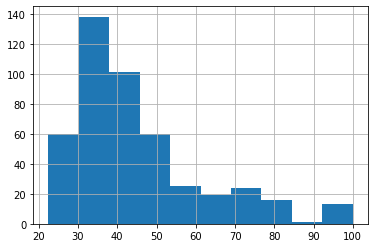

In [50]:
blast_table['pident'].hist()

In [51]:
labels = []
with open("../data/curvibacter_dna_genomes_for_rec_blast/curvibacter_aep_eps_operon.faa",'r') as qfile:
    for line in qfile.readlines():
        if line.startswith(">"):
            labels.append(line)
labels

['>WP_087496569.1 polyprenyl synthetase family protein\n',
 '>WP_087496568.1 PEP-CTERM sorting domain-containing protein\n',
 '>WP_087496564.1 transcriptional regulator EpsA\n',
 '>WP_087496563.1 undecaprenyl-phosphate glucosephosphotransferase\n',
 '>WP_087496562.1 putative exosortase B-associated extracellularpolysaccharide biosynthesis transporter EpsL\n',
 '>WP_087496561.1 EpsD family peptidyl-prolyl cis-trans isomerase\n',
 '>WP_087496560.1 polysaccharide export protein EpsE\n',
 '>WP_087496559.1 chain length determinant protein EpsF\n',
 '>WP_087496558.1 chain length determinant protein tyrosine kinase EpsG\n',
 '>WP_087496557.1 exosortase B\n',
 '>WP_087496556.1 EpsI family protein\n',
 '>WP_087496555.1 WecB/TagA/CpsF family glycosyltransferase\n']

In [52]:
labels_dict = {}
labels_dict['WP_087496569.1'] = "polyprenyl synthetase"
labels_dict['WP_087496568.1'] = "PEP-CTERM"
labels_dict['WP_087496564.1'] = "EpsA"
labels_dict['WP_087496563.1'] = "UDP PGT"#"UDP glycosylphosphotransferase"
labels_dict['WP_087496562.1'] = "EpsL"
labels_dict['WP_087496561.1'] = "EpsD"
labels_dict['WP_087496560.1'] = "EpsE"
labels_dict['WP_087496559.1'] = "EpsF"
labels_dict['WP_087496558.1'] = "EpsG"
labels_dict['WP_087496557.1'] = "exosortase B/EpsH"
labels_dict['WP_087496556.1'] = "EpsI"
labels_dict['WP_087496555.1'] = "Glycosyltransferase"#"WecB/TagA/CpsF glycosyltransferase"

[*] Found 12 taxids for query sequence WP_087496569.1
	[*] Setting label to: polyprenyl synthetase
[*] Found 6 taxids for query sequence WP_087496568.1
	[*] Setting label to: PEP-CTERM
[*] Found 12 taxids for query sequence WP_087496564.1
	[*] Setting label to: EpsA
[*] Found 12 taxids for query sequence WP_087496563.1
	[*] Setting label to: UDP PGT
[*] Found 8 taxids for query sequence WP_087496562.1
	[*] Setting label to: EpsL
[*] Found 9 taxids for query sequence WP_087496561.1
	[*] Setting label to: EpsD
[*] Found 9 taxids for query sequence WP_087496560.1
	[*] Setting label to: EpsE
[*] Found 8 taxids for query sequence WP_087496559.1
	[*] Setting label to: EpsF
[*] Found 12 taxids for query sequence WP_087496558.1
	[*] Setting label to: EpsG
[*] Found 5 taxids for query sequence WP_087496557.1
	[*] Setting label to: exosortase B/EpsH
[*] Found 10 taxids for query sequence WP_087496556.1
	[*] Setting label to: EpsI
[*] Found 10 taxids for query sequence WP_087496555.1
	[*] Setting

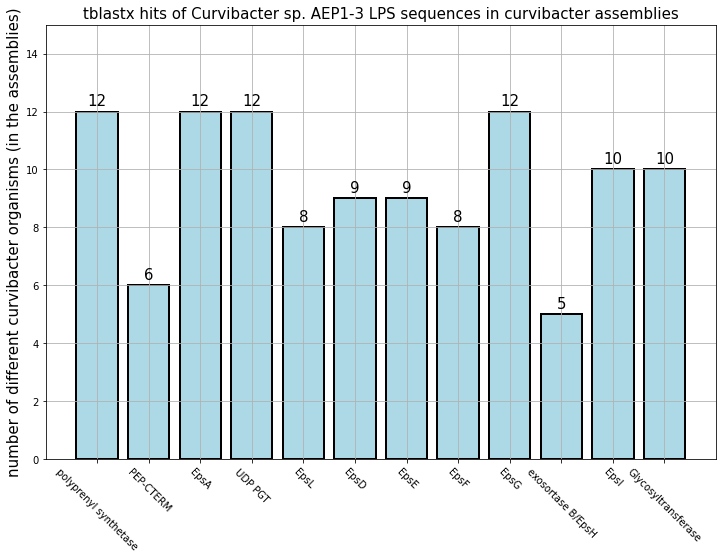

In [53]:
hits = []
queries = []
for qseqid in blast_table['qseqid'].unique():
    sub_df = blast_table[blast_table['qseqid'] == qseqid]
    unique_taxids = sub_df['staxids'].unique()
    print("[*] Found {} taxids for query sequence {}".format(len(unique_taxids),qseqid))
    hits.append(len(unique_taxids))
    print("\t[*] Setting label to: {}".format(labels_dict[qseqid]))
    queries.append(labels_dict[qseqid])
    
fsize=15
plt.figure(figsize=(12,8))
plt.bar(height=hits,x=range(len(hits)),color="lightblue", edgecolor="black", lw=2)
for height, xtick in zip(hits, range(len(hits))):
    plt.text(xtick,height+0.2,"{}".format(height),fontsize=fsize,ha='center')
plt.xticks(ticks=range(len(hits)),labels=queries, rotation=-45)
plt.ylabel("number of different curvibacter organisms (in the assemblies)", fontsize=fsize)
plt.title("tblastx hits of Curvibacter sp. AEP1-3 LPS sequences in curvibacter assemblies", fontsize=fsize)
plt.ylim(0,15)
plt.grid()

In [6]:
c_lanceolatus = blast_table[blast_table['stitle'].str.contains('lanceolatus')]
sorted_c_lanceolatus = c_lanceolatus.sort_values(by=['sstart','send'],ascending=False)

In [7]:
sorted_c_lanceolatus

,qseqid,sseqid,evalue,bitscore,pident,mismatch,qstart,qend,sstart,send,sacc,staxids,stitle
180,WP_087496564.1,gb|KB906253.1|,4.210000e-06,49.3,40.323,35,206,265,724387,724572,KB906253,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
40,WP_087496569.1,gb|KB906253.1|,1.100000e-18,88.2,41.176,104,1,196,694489,693902,KB906253,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
431,WP_087496556.1,gb|JAFLKI010000010.1|,1.400000e+00,31.6,31.081,39,7,68,550891,551112,JAFLKI010000010,86182,MAG: Curvibacter lanceolatus isolate LaCa_MAG_...
232,WP_087496564.1,gb|KB906254.1|,1.900000e+00,31.6,33.333,32,206,253,445591,445734,KB906254,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
170,WP_087496564.1,gb|KB906255.1|,3.000000e-03,40.4,36.207,37,206,263,433567,433740,KB906255,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
355,WP_087496558.1,gb|KB906254.1|,1.660000e-04,44.7,30.709,78,118,240,432799,432437,KB906254,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
160,WP_087496564.1,gb|JAFLKI010000026.1|,1.880000e-07,53.5,48.148,28,203,256,415351,415512,JAFLKI010000026,86182,MAG: Curvibacter lanceolatus isolate LaCa_MAG_...
279,WP_087496562.1,gb|KB906257.1|,1.100000e+00,33.1,23.588,179,37,292,276452,277336,KB906257,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
344,WP_087496558.1,gb|KB906257.1|,5.690000e-34,132.0,37.456,170,10,290,269130,269963,KB906257,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...
324,WP_087496559.1,gb|KB906257.1|,9.460000e-32,130.0,26.498,300,1,426,267738,269006,KB906257,86182,Curvibacter lanceolatus ATCC 14669 genomic sca...


In [60]:
genome_files = !ls ../data/curvibacter_dna_genomes_for_rec_blast/*.fna

In [61]:
for file in genome_files:
    new_output_filename = file.split("/")[-1].split('.')[0:2]
    new_output_filename = '../data/curvibacter_dna_genomes_for_rec_blast/' + new_output_filename[0] + '.' + new_output_filename[1] + '_transformed.fna'
    if os.path.isfile(new_output_filename) == False:
        try:
            print("[+] Starting to transform FASTA: {}".format(file))
            new_output_file = open(new_output_filename,'w')
            with open(file,'r') as genome_file:
                counter = 0
                for line in genome_file.readlines():
                    if line.startswith('>') and counter == 0:
                        counter = 1
                        new_output_file.write(line)
                    elif line.startswith('>'):
                        continue
                    else:
                        new_output_file.write(line)
            new_output_file.close()
            print("\t[+] DONE")
        except IOError as e:
            raise Exception("[-] ERROR during file reading or writing with Exception: {}".format(e))
    else:
        continue
        #print("[*] File Already Exists!")

[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_000381265.1_ASM38126v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_000518645.1_ASM51864v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_001432305.1_ASM143230v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_001592265.1_ASM159226v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_001795455.1_ASM179545v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_001795465.1_ASM179546v1_genomic_transformed.fna
	[+] DONE
[+] Starting to transform FASTA: ../data/curvibacter_dna_genomes_for_rec_blast/GCA_001797315.1_ASM179731v1_genomic_transformed.fna
	[+] DONE
[+] Starting to

In [3]:
rec_blast_df = pd.read_csv("../data/curvibacter_dna_genomes_for_rec_blast/rec_blast_result/reciprocal_results.csv",header=0,index_col=0)

In [63]:
#rec_blast_df['sscinames'].unique()

In [64]:
#rec_blast_df[rec_blast_df['sscinames'] == 'Curvibacter delicatus'].sort_values(by=['qseqid'])

In [65]:
#rec_blast_df[rec_blast_df['qseqid'] == 'WP_087496557'].sort_values(by=['sacc'])

In [66]:
#assemblies[assemblies['SpeciesName'] == 'Curvibacter sp.']

In [3]:

directories = !ls ../data/curvibacter_dna_genomes_for_rec_blast/prokka/*_* -d
for d in directories:
    genome_fasta = !ls $d/*.faa
    switch = 0
    
    with open(genome_fasta[0], 'r') as gfile:
        lines = gfile.readlines()
        lines = lines[0].split('>')[-1].split(" ")[0].split("_")[0]
        if lines == 'KANBEJMG':
            print(d)
            switch = 1
            
    if switch == 1:
        break


../data/curvibacter_dna_genomes_for_rec_blast/prokka/GCA_003987795


In [21]:
assemblies[assemblies['AssemblyAccession'].str.contains('GCF_018474005')]['SpeciesName'].values[0]

'Curvibacter sp. CHRR-16'

In [31]:
msa_file_name = '../data/curvibacter_dna_genomes_for_rec_blast/rec_blast_result/trees/gyraseA.msa'

output_name = '../data/curvibacter_dna_genomes_for_rec_blast/rec_blast_result/trees/header_changed_gyraseA.msa'
output = open(output_name,"w")
with open(msa_file_name,'r') as msa_file:
    for line in msa_file.readlines():
        if line.startswith(">"):
            line = line.split(">")[1].split(" ")[0]
            print(line)
            for d in directories:
                genome_fasta = !ls $d/*.faa
                switch = 0

                with open(genome_fasta[0], 'r') as gfile:
                    lines = gfile.readlines()
                    lines = lines[0].split('>')[-1].split(" ")[0].split("_")[0]
                    if lines == line.split("_")[0]:
                        name = assemblies[assemblies['AssemblyAccession'].str.contains(d.split("/")[-1])]['SpeciesName'].values[0]
                        name = name + ' ' + str(d.split("/")[-1])
                        print(name)
                        switch = 1
                    else:
                        name = "Curvibacter "+line.split("_")[0]
                if switch == 1:
                    break
            name = "_".join(name.split(" "))
            output.write(">"+name+"\n")
        else:
            output.write(line)
output.close()            

ALBLECJD_01915
Curvibacter sp. GCA_004293725
MGDKJGCL_00761
uncultured Curvibacter sp. GCA_903828535
CAKLEEPK_00438
uncultured Curvibacter sp. GCA_903868085
JOPOJBGG_05526
Curvibacter lanceolatus GCF_000381265
PLDEBCFB_00746
Curvibacter sp. GCA_020621965
IGILBMNO_02007
uncultured Curvibacter sp. GCA_903902035
Hvu_03561
BCBDKMGJ_01330
uncultured Curvibacter sp. GCA_903890985
ENNBNNNG_02102
Curvibacter sp. CHRR-16 GCF_018474005
BG3_02606
JODDCPHN_01248
Curvibacter sp. GCA_020248905
NFEFLOND_03562
Curvibacter lanceolatus GCA_019163435
PLDEBCFB_03042
Curvibacter sp. GCA_020621965
Hma_03368
CFAHILJL_03352
uncultured Curvibacter sp. GCA_903824395
DFCICLJG_01409
Curvibacter sp. GWA2_63_95 GCA_001795455
AFMONPIJ_03950
Curvibacter sp. AEP1-3 GCF_002163715
KANBEJMG_00906
Curvibacter sp. GCA_003987795
FNBHNKKP_00502
Curvibacter delicatus GCF_001592265
EKLJCEDL_00549
uncultured Curvibacter sp. GCA_903834975
CNGHKECC_00738
uncultured Curvibacter sp. GCA_903950315
ELAPIOON_00830
Curvibacter sp. PD_M

In [19]:
directories = !ls ../data/curvibacter_dna_genomes_for_rec_blast/prokka/*_* -d

msa_file_name = '../data/lps_synthesis/heatmap/epsF.faa'

output_name = '../data/lps_synthesis/heatmap/changed_header_epsF.faa'
output = open(output_name,"w")
with open(msa_file_name,'r') as msa_file:
    for line in msa_file.readlines():
        if line.startswith(">"):
            ids = line.split('>')[-1]
            ids = ids.rstrip()
            ids = ids + ' '
            line = line.split(">")[1].split(" ")[0]
            #print(line)
            for d in directories:
                genome_fasta = !ls $d/*.faa
                switch = 0

                with open(genome_fasta[0], 'r') as gfile:
                    lines = gfile.readlines()
                    
                    lines = lines[0].split('>')[-1].split(" ")[0].split("_")[0]
                    if lines == line.split("_")[0]:
                        name = assemblies[assemblies['AssemblyAccession'].str.contains(d.split("/")[-1])]['SpeciesName'].values[0]
                        name = ">" + ids  + str(d.split("/")[-1]) + " [" + name + '] '
                        switch = 1
                    else:
                        name = ">" + ids + " [Curvibacter "+line.split("_")[0]+"]"
                        #switch = 1
                if switch == 1:
                    break
            #name = "_".join(name.split(" "))
            print(name)
            output.write(name)
        else:
            output.write(line)
output.close()            

>KANBEJMG_01714 hypothetical protein GCA_003987795 [Curvibacter sp.] 
>AFMONPIJ_03481 hypothetical protein GCF_002163715 [Curvibacter sp. AEP1-3] 
>CICGHEPH_00139 hypothetical protein GCA_903840155 [uncultured Curvibacter sp.] 
>JOPOJBGG_02319 hypothetical protein GCF_000381265 [Curvibacter lanceolatus] 
>HGNGCGOJ_03036 hypothetical protein GCF_000518645 [Curvibacter gracilis] 
>Hma_02881 Tyrosine-protein kinase ptk  [Curvibacter Hma]
>EICPHKOE_01477 hypothetical protein GCA_001795465 [Curvibacter sp. RIFCSPHIGHO2_12_FULL_63_18] 
>DFCICLJG_00797 hypothetical protein GCA_001795455 [Curvibacter sp. GWA2_63_95] 
>ENNBNNNG_02891 hypothetical protein GCF_018474005 [Curvibacter sp. CHRR-16] 
>MGDKJGCL_01541 hypothetical protein GCA_903828535 [uncultured Curvibacter sp.] 
>JOPOJBGG_04840 Tyrosine-protein kinase wzc GCF_000381265 [Curvibacter lanceolatus] 
>JPBAHNHP_03999 hypothetical protein GCA_019233055 [Curvibacter sp.] 
>Hvu_03071 Tyrosine-protein kinase ptk  [Curvibacter Hvu]
>HGNGCGOJ_0

In [1]:
dirs = !ls -d ../data/curvibacter_dna_genomes_for_rec_blast/prokka/*
dirs = [d for d in dirs if d.split("/")[-1] != "database"]

In [7]:
for d in dirs:
    !cp $d/*.faa ../data/curvibacter_dna_genomes_for_rec_blast/prokka/